## Example notebook to show how to use graph builder package

#### Importing data

Data can be extracted from `ExpressionSet`s. We build a data structure of the following form:
    
- Dict{ transform_name : Hexel} where Hexel has as attributes transform, best_pairings, description, github commit and color.


In [1]:
from kymata.datasets.sample import KymataMirror2023Q3Dataset
from kymata.entities.expression import HexelExpressionSet
from kymata.ippm.denoising_strategies import DBSCANStrategy
from kymata.ippm.ippm import IPPM
from kymata.ippm.plot import plot_ippm
from kymata.plot.plot import expression_plot

In [ ]:
expression_set: HexelExpressionSet = KymataMirror2023Q3Dataset().to_expressionset()

#### Plotting data

stem_plot is a useful transform to plot all of the data in hexels. Takes the hexels data structure illustrated above as input along with title.

In [ ]:
expression_plot(expression_set, title='Kymata 2023 Q3 Dataset')

#### Denoising

The first iteration of the denoiser is a max pooling strategy. It partitions the x-axis into bins and looks for clusters of spikes in each bin for each transform. If a cluster is found, it takes the maximum. The returned hexels have the best_pairings reduced significantly.

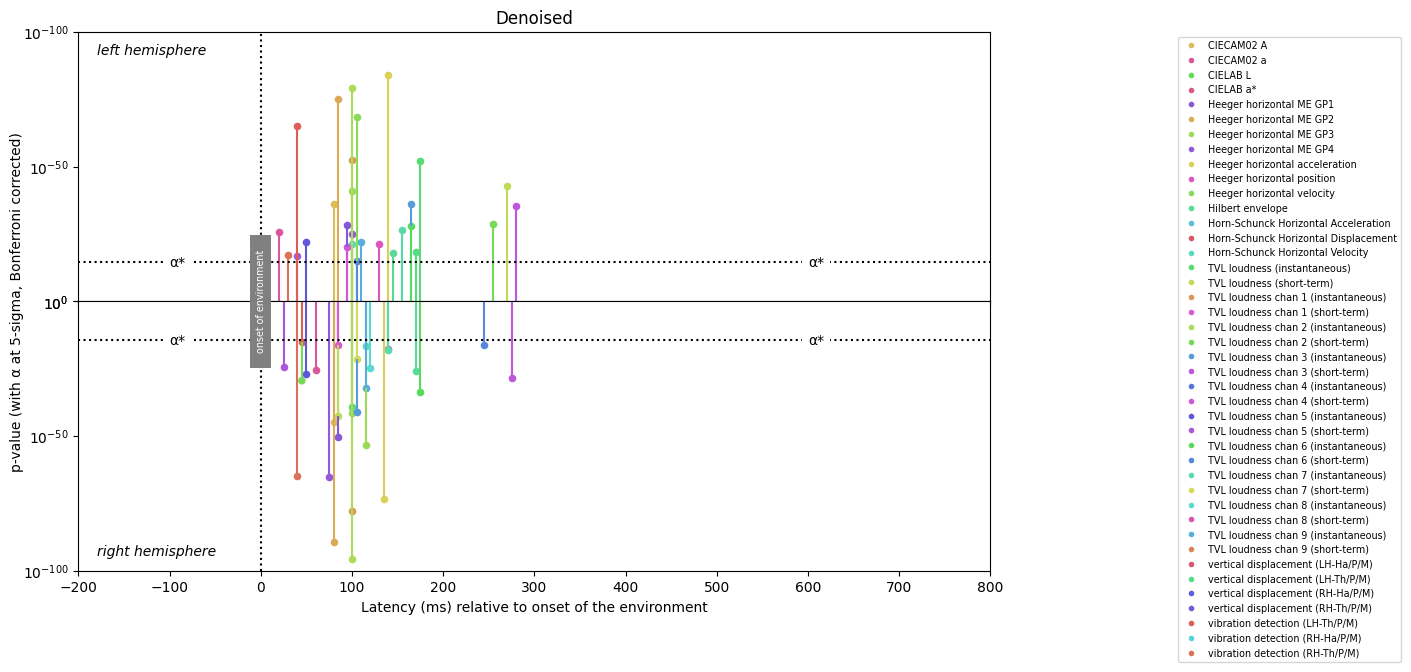

In [4]:
'''
For more details on each algorithm, check the denoiser.py file and ctrl-f search for the names. If further details are required, you can check the relevant sklearn page too.
Strategies
----------
- Max Pooler : hyperparameters = [num_clusters, bin_sz]
               num_clusters is the threshold for a bin to be considered a cluster. default=15
               bin_sz is the size of the bin in ms. default = 25
- Gaussian Mixture : hyperparameters = [max_gaussians, covariance_type, max_iter, n_init, init_params, random_state]
               max_gaussians indicates the maximum number of gaussians in the mixture. default = 5.
               covariance_type = [full, tied, diag, spherical]. default = full
                               specifies the covariance matrix of the Gaussians
               max_iter is the # of iterations til stop. default = 1000.
               n_init = # of initialisations. default = 8
               init_params = [kmeans, k-means++, random, random_from_data]. default = kmeans
                            specifies how to initialise the parameters
               random_state is a seed. Set it for reproducibility. default = None
- DBSCAN : hyperparameters = [eps, min_samples, metric, metric_params, algorithm, leaf_size, n_jobs]
               eps is the maximum distance between two samples to be considered in the neighbourhood.
                   default = 10.
               min_samples the number of samples in a neighbourhood for a point to be a core point.
                   default = 2
               metric used to compute distance. default = euclidean. check sklearn.metrics.pairwise_distance
               metric_params additional params for metric. default = None.
               algorithm = [auto, ball_tree, kd_tree, brute]. default = auto
                         the algorithm used by nearestneighbours to compute distance.
               leaf_size leaf size for ball_tree or kd_tree. default=30
               n_jobs is the number of processors to use. default = -1.
- Mean Shift : hyperparameters = [bandwidth, seeds, min_bin_freq, cluster_all, n_jobs]
               bandwidth the bandwidth of the kernel. default = 30
               seeds seeds used to initialise kernels. default = None
               min_bin_freq accept only those bins with at least min_bin_freq points. default = 1
               cluster_all false means to ignore anomalies. default = False
               n_jobs is the number of processors to use. default = -1.
the inputs for the strategy parameters are [max pooler, gaussian mixture, dbscan, mean shift].
'''
# algos : denoiser.[MaxPooler, DBSCAN, GMM, MeanShift]

hyperparams = {
    "n_timepoints": 201,
    "n_hexels": 200_000,
    "should_normalise": True,
    "should_cluster_only_latency": True,
    "should_max_pool": False,
    "normal_dist_threshold": 5,
    "should_exclude_insignificant": True,
    "should_shuffle": True,
    "eps": 0.005,
    "min_samples": 1,
    "metric": "cosine",
    "algorithm": "auto",
    "leaf_size": 30,
    "n_jobs": -1,
}

denoised_es: HexelExpressionSet = DBSCANStrategy(**hyperparams).denoise(expression_set)

expression_plot(denoised_es, title='Denoised')

#### Generating the Directed Graph

To generate a graph, we need relations between transforms, in the form of a transform hierarchy. It is 
a dictionary containing transform names with their children. Furthermore, this dictionary needs to
contain the input transform too. 

An additional input is the list of input transforms. This is so we can differentiate between the spikes and inputs. Finally, it also takes the hemisphere and title as input.

The result graph has as the y-axis the latency of spike, x-axis as class partitions, and node sizes as the magnitude of the spike. 

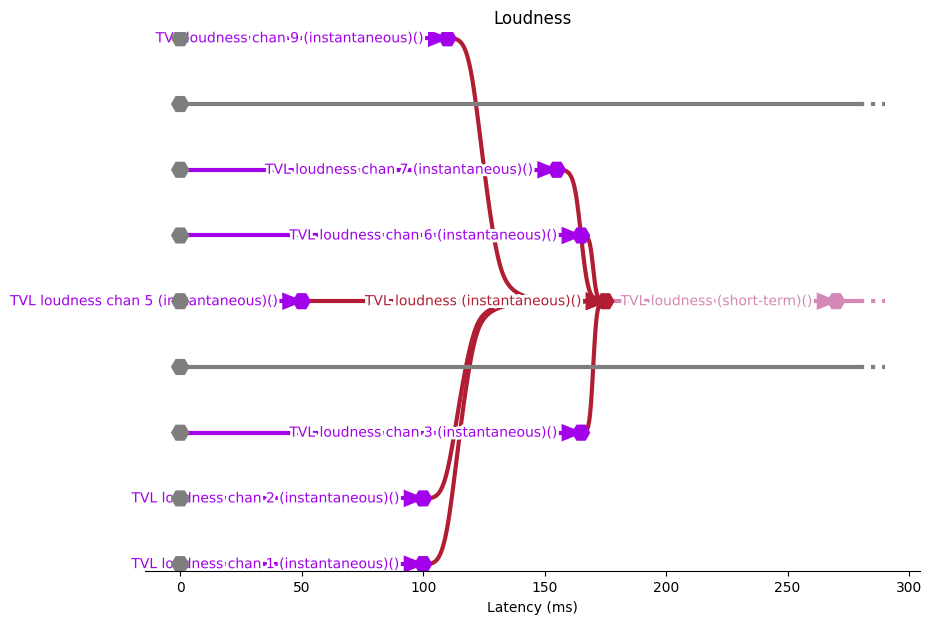

In [5]:
transform_hier = {
    # assumption: we have a list of transforms and their children transform
    'TVL loudness (short-term)' : ['TVL loudness (instantaneous)'],
    'TVL loudness (instantaneous)' : [
        'TVL loudness chan 1 (instantaneous)',
        'TVL loudness chan 2 (instantaneous)',
        'TVL loudness chan 3 (instantaneous)',
        'TVL loudness chan 4 (instantaneous)',
        'TVL loudness chan 5 (instantaneous)',
        'TVL loudness chan 6 (instantaneous)',
        'TVL loudness chan 7 (instantaneous)',
        'TVL loudness chan 8 (instantaneous)',
        'TVL loudness chan 9 (instantaneous)'],
    'TVL loudness chan 1 (instantaneous)' : ['input_cochlear_1'],
    'TVL loudness chan 2 (instantaneous)' : ['input_cochlear_2'],
    'TVL loudness chan 3 (instantaneous)' : ['input_cochlear_3'],
    'TVL loudness chan 4 (instantaneous)' : ['input_cochlear_4'],
    'TVL loudness chan 5 (instantaneous)' : ['input_cochlear_5'],
    'TVL loudness chan 6 (instantaneous)' : ['input_cochlear_6'],
    'TVL loudness chan 7 (instantaneous)' : ['input_cochlear_7'],
    'TVL loudness chan 8 (instantaneous)' : ['input_cochlear_8'],
    'TVL loudness chan 9 (instantaneous)' : ['input_cochlear_9'],
    'input_cochlear_1' : [],
    'input_cochlear_2' : [],
    'input_cochlear_3' : [],
    'input_cochlear_4' : [],
    'input_cochlear_5' : [],
    'input_cochlear_6' : [],
    'input_cochlear_7' : [],
    'input_cochlear_8' : [],
    'input_cochlear_9' : [],
}
transform_colour_overrides = {
    # Transforms and their colours to match the figures
    'TVL loudness (short-term)' : '#d388b5',
    'TVL loudness (instantaneous)' : '#b11e34',
} | {
    f'TVL loudness chan {i} (instantaneous)' : '#a201e9' for i in list('123456789')
} | {
    f'input_cochlear_{i}' : '#7e7e7e' for i in list('123456789')
}
ippm = IPPM(expression_set, hierarchy=transform_hier, denoiser="dbscan",
            # Pass the same denoising parameteres
            **{f"denoise_{hp}": val for hp, val in hyperparams.items()})
plot_ippm(ippm, title='Loudness', figheight=7, figwidth=10, colors=transform_colour_overrides)

In [ ]:
transform_hier = {
    'Heeger horizontal acceleration' : ['Heeger horizontal velocity'],
    'Heeger horizontal velocity' : [
        'Heeger horizontal ME GP1', 
        'Heeger horizontal ME GP2', 
        'Heeger horizontal ME GP3',
        'Heeger horizontal ME GP4',
    ],
    'Heeger horizontal ME GP1' : [f'input_photoreceptors_{i}' for i in list('12345')],
    'Heeger horizontal ME GP2' : [f'input_photoreceptors_{i}' for i in list('12345')],
    'Heeger horizontal ME GP3' : [f'input_photoreceptors_{i}' for i in list('12345')],
    'Heeger horizontal ME GP4' : [f'input_photoreceptors_{i}' for i in list('12345')],
    'input_photoreceptors_1': [],
    'input_photoreceptors_2': [],
    'input_photoreceptors_3': [],
    'input_photoreceptors_4': [],
    'input_photoreceptors_5': [],
}
transform_colour_overrides = {
    # Transforms and their colours to match the figures
    'Heeger horizontal acceleration' : '#68d366',
    'Heeger horizontal velocity' : '#3165e0',
    'Heeger horizontal ME GP1' : '#fdf351',
    'Heeger horizontal ME GP2' : '#f8d748',
    'Heeger horizontal ME GP3' : '#eda13a',
    'Heeger horizontal ME GP4' : '#ed732e',
} | {
    f'input_photoreceptors_{i}' : '#7e7e7e' for i in list('12345')
}
ippm = IPPM(expression_set, hierarchy=transform_hier, denoiser="dbscan",
            # Pass the same denoising parameteres
            **{f"denoise_{hp}": val for hp, val in hyperparams.items()})
plot_ippm(ippm, title='Motion', figheight=7, figwidth=10, colors=transform_colour_overrides)